In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
columns = ["training",   # Treatment assignment indicator
           "age",        # Age of participant
           "education",  # Years of education
           "black",      # Indicate whether individual is black
           "hispanic",   # Indicate whether individual is hispanic
           "married",    # Indicate whether individual is married
           "no_degree",  # Indicate if individual has no high-school diploma
           "re74",       # Real earnings in 1974, prior to study participation
           "re75",       # Real earnings in 1975, prior to study participation
           "re78"]       # Real earnings in 1978, after study end

# treated = pd.read_csv("http://www.nber.org/~rdehejia/data/nswre74_treated.txt",
#                      delim_whitespace=True, header=None, names=columns)
# control = pd.read_csv("http://www.nber.org/~rdehejia/data/nswre74_control.txt",
#                      delim_whitespace=True, header=None, names=columns)
file_names = ["http://www.nber.org/~rdehejia/data/nswre74_treated.txt",
              "http://www.nber.org/~rdehejia/data/nswre74_control.txt",
              "http://www.nber.org/~rdehejia/data/psid_controls.txt",
              "http://www.nber.org/~rdehejia/data/psid2_controls.txt",
              "http://www.nber.org/~rdehejia/data/psid3_controls.txt",
              "http://www.nber.org/~rdehejia/data/cps_controls.txt",
              "http://www.nber.org/~rdehejia/data/cps2_controls.txt",
              "http://www.nber.org/~rdehejia/data/cps3_controls.txt"]
files = [pd.read_csv(file_name, delim_whitespace=True,
                     header=None, names=columns) for file_name in file_names]
lalonde = pd.concat(files, ignore_index=True)
lalonde = lalonde.sample(frac=1.0, random_state=42)  # Shuffle

print(lalonde.shape)
lalonde.head()

(22106, 10)


,training,age,education,black,hispanic,married,no_degree,re74,re75,re78
16827,0.0,26.0,13.0,0.0,0.0,0.0,0.0,58.778,50.12903,31.03226
5412,0.0,27.0,12.0,0.0,0.0,1.0,0.0,16297.180,13429.21000,19562.14000
15399,0.0,26.0,12.0,0.0,0.0,0.0,0.0,5217.527,3174.24200,25564.67000
13077,0.0,38.0,16.0,0.0,0.0,1.0,0.0,23713.010,9178.98400,18814.41000
2189,0.0,55.0,8.0,0.0,0.0,1.0,1.0,0.000,0.00000,0.00000


In [3]:
lalonde = lalonde.join((lalonde[["re74", "re75"]] == 0).astype(int), rsuffix=("=0"))
lalonde.head()

,training,age,education,black,hispanic,married,no_degree,re74,re75,re78,re74=0,re75=0
16827,0.0,26.0,13.0,0.0,0.0,0.0,0.0,58.778,50.12903,31.03226,0,0
5412,0.0,27.0,12.0,0.0,0.0,1.0,0.0,16297.180,13429.21000,19562.14000,0,0
15399,0.0,26.0,12.0,0.0,0.0,0.0,0.0,5217.527,3174.24200,25564.67000,0,0
13077,0.0,38.0,16.0,0.0,0.0,1.0,0.0,23713.010,9178.98400,18814.41000,0,0
2189,0.0,55.0,8.0,0.0,0.0,1.0,1.0,0.000,0.00000,0.00000,1,1


In [4]:
print(lalonde.shape)
lalonde.head()

(22106, 12)


,training,age,education,black,hispanic,married,no_degree,re74,re75,re78,re74=0,re75=0
16827,0.0,26.0,13.0,0.0,0.0,0.0,0.0,58.778,50.12903,31.03226,0,0
5412,0.0,27.0,12.0,0.0,0.0,1.0,0.0,16297.180,13429.21000,19562.14000,0,0
15399,0.0,26.0,12.0,0.0,0.0,0.0,0.0,5217.527,3174.24200,25564.67000,0,0
13077,0.0,38.0,16.0,0.0,0.0,1.0,0.0,23713.010,9178.98400,18814.41000,0,0
2189,0.0,55.0,8.0,0.0,0.0,1.0,1.0,0.000,0.00000,0.00000,1,1


In [5]:
a = lalonde.pop("training")
y = lalonde.pop("re78")
X = lalonde
X.shape, a.shape, y.shape

((22106, 10), (22106,), (22106,))

In [6]:
from sklearn.linear_model import LogisticRegression
from causallib.estimation import IPW

lr = LogisticRegression(solver='lbfgs', max_iter=1000)
ipw = IPW(lr)
ipw.fit(X, a)
propMatrix = ipw.compute_propensity_matrix(X, a)

In [8]:
# X.to_json("../public/cohort_confounds_matched_unadjusted.json", orient="records")
# y.to_json("../public/cohort_outcome_matched_unadjusted.json", orient="records")
# a.to_json("../public/cohort_treatment_matched_unadjusted.json", orient="records")
# propMatrix.to_json("../public/cohort_propensity_matched_unadjusted.json", orient="records")

In [6]:
from causallib.estimation import IPW, Matching
from causallib.preprocessing.transformers import PropensityTransformer
from sklearn.linear_model import LogisticRegression
import pandas as pd


def learner(): return LogisticRegression(solver="liblinear",
                                         max_iter=5000,
                                         class_weight="balanced")

In [7]:
try:
    from causallib.contrib.faissknn import FaissNearestNeighbors
    knn_backend = FaissNearestNeighbors
except ImportError:
    knn_backend = "sklearn"

In [8]:
propensity_transform = PropensityTransformer(
    include_covariates=False, learner=learner())
matcher = Matching(propensity_transform=propensity_transform,
                   with_replacement=True, n_neighbors=1, knn_backend=knn_backend)
matcher.fit(X, a, y)
matcher.match(X, a)

distances  matches
match_to_treatment sample_id                                 
0.0                16827                         [0]  [16827]
                   5412                          [0]   [5412]
                   15399                         [0]  [15399]
                   13077                         [0]  [13077]
                   2189                          [0]   [2189]
...                                              ...      ...
1.0                11964       [0.02948362549097045]    [178]
                   21575                       [0.0]     [91]
                   5390       [0.019566321448961532]    [171]
                   860        [0.058750986186836135]    [178]
                   15795      [0.005773568862548206]     [41]

[44212 rows x 2 columns]

In [9]:
best_control_matches = matcher.get_covariates_of_matches(1, 0, X)
best_treatment_matches = matcher.get_covariates_of_matches(0, 1, X)

In [10]:
best_control_matches.sort_values(("match", "distance"), ascending=False)["delta"].head(10)

,age,education,black,hispanic,married,no_degree,re74,re75,re74=0,re75=0
2274,23.0,0.0,0.0,0.0,1.0,0.0,130388.686,148197.726,0.0,0.0
18914,33.0,5.0,0.0,0.0,1.0,0.0,81407.012,90012.238,0.0,0.0
12877,27.0,4.0,0.0,0.0,1.0,0.0,87284.813,90012.238,0.0,0.0
3310,20.0,4.0,0.0,0.0,1.0,0.0,97081.146,84641.270,0.0,0.0
253,15.0,5.0,0.0,0.0,1.0,0.0,75529.212,76584.819,0.0,0.0
17098,6.0,4.0,0.0,0.0,1.0,0.0,91203.346,81060.625,0.0,0.0
4605,25.0,4.0,0.0,0.0,1.0,0.0,71610.678,70318.690,0.0,0.0
11638,33.0,4.0,0.0,0.0,1.0,0.0,42221.676,63157.399,0.0,0.0
6670,11.0,4.0,0.0,1.0,1.0,0.0,28506.808,77479.980,0.0,0.0
21105,16.0,1.0,0.0,0.0,1.0,0.0,44180.943,64947.722,0.0,0.0


In [11]:
best_treatment_matches.sort_values(("match", "distance"), ascending=False)["delta"].head(10)

,age,education,black,hispanic,married,no_degree,re74,re75,re74=0,re75=0
142,23.0,-4.0,1.0,-1.0,-1.0,1.0,3165.6580,2378.0940,-1.0,0.0
103,30.0,4.0,0.0,0.0,0.0,-1.0,-2870.3260,-785.9516,1.0,1.0
93,8.0,1.0,0.0,0.0,1.0,-1.0,-11917.0550,-10407.8857,0.0,0.0
130,8.0,-1.0,0.0,0.0,0.0,1.0,-2849.6230,-1241.8860,0.0,0.0
115,0.0,2.0,0.0,0.0,0.0,0.0,-4829.4348,-3580.6452,0.0,1.0
127,21.0,-1.0,0.0,0.0,0.0,1.0,0.0000,-6640.3060,0.0,1.0
11,29.0,-8.0,0.0,0.0,0.0,1.0,0.0000,-6640.3060,0.0,1.0
76,-9.0,-2.0,0.0,0.0,0.0,1.0,-2163.3790,3800.9480,0.0,0.0
83,2.0,-2.0,0.0,0.0,0.0,1.0,-4392.7160,583.5100,0.0,0.0
184,5.0,-10.0,0.0,0.0,0.0,1.0,4552.0330,3405.5497,0.0,0.0


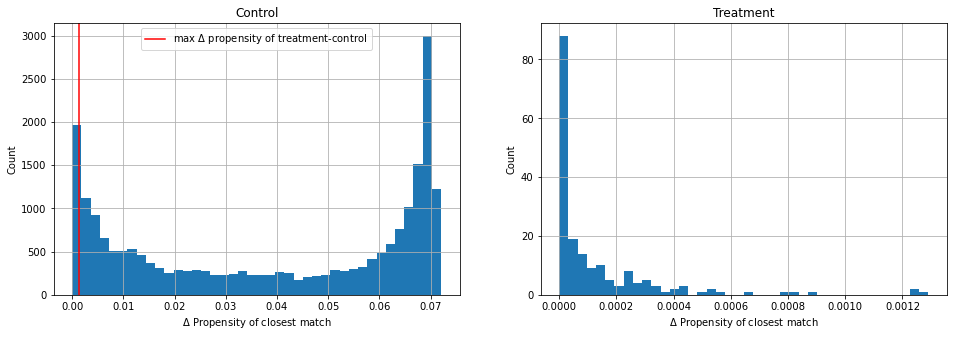

In [12]:
f, axes = plt.subplots(1, 2, figsize=(16, 5))
best_control_matches.match.distance.hist(ax=axes[0], bins=40)
best_treatment_matches.match.distance.hist(ax=axes[1], bins=40)
axes[0].set_xlabel("$\Delta$ Propensity of closest match")
axes[1].set_xlabel("$\Delta$ Propensity of closest match")
axes[0].set_ylabel("Count")
axes[1].set_ylabel("Count")
axes[0].set_title("Control")
axes[1].set_title("Treatment")
axes[0].axvline(x=best_treatment_matches.match.distance.max(
), color="red", label="max $\Delta$ propensity of treatment-control")
axes[0].legend();

In [13]:
matcher.with_replacement = False
matcher.match(X, a)
matcher.estimate_population_outcome(X, a)

0.0    14536.175529
1.0    10176.591566
dtype: float64

In [14]:
matcher.n_neighbors = 3
results, sample_count = [[], []]
cvec = np.logspace(-7, -0.5, 10)
for caliper in cvec:
    matcher.caliper = caliper
    matcher.with_replacement = False
    matcher.match(X, a)
    results.append(matcher.estimate_population_outcome(X, a))
    sample_count.append(matcher.samples_used_)
cresults = pd.DataFrame(data=results, index=cvec)

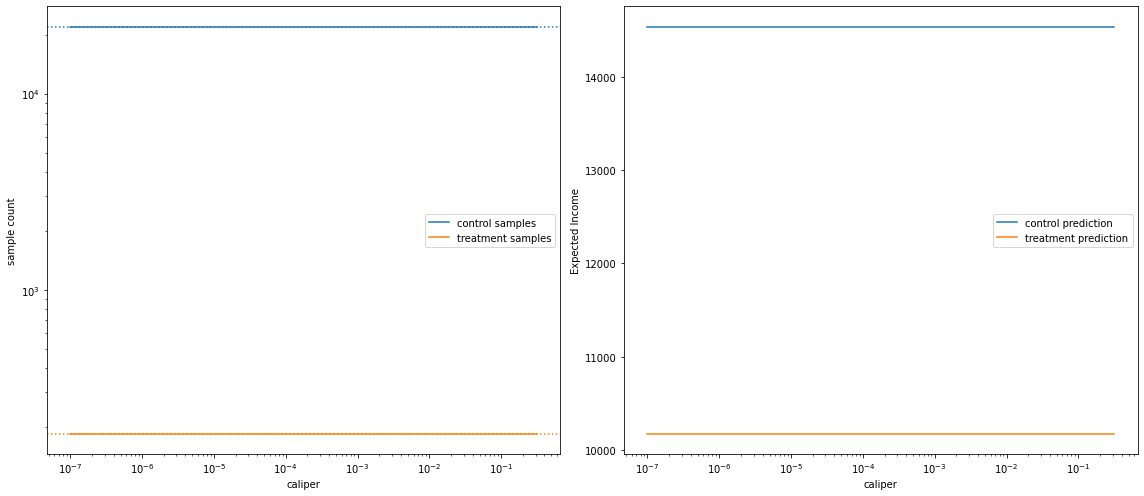

In [15]:
f, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].loglog(cvec, sample_count)
axes[0].legend(["control samples", "treatment samples"])
axes[0].axhline(y=sum(a == 0), ls=":", color="C0")
axes[0].axhline(y=sum(a == 1), ls=":", color="C1")
axes[0].set_xlabel("caliper")
axes[0].set_ylabel("sample count")
axes[0].axis("tight")

axes[1].semilogx(cvec, results)
axes[1].legend(["control prediction", "treatment prediction"])
axes[1].set_xlabel("caliper")
axes[1].set_ylabel("Expected Income")

plt.tight_layout();

In [16]:
cvec = np.logspace(-7, -0.5, 10)
cvec

array([1.00000000e-07, 5.27499706e-07, 2.78255940e-06, 1.46779927e-05,
       7.74263683e-05, 4.08423865e-04, 2.15443469e-03, 1.13646367e-02,
       5.99484250e-02, 3.16227766e-01])

In [17]:
matcher.n_neighbors = 3
matcher.caliper = cvec[0]
matcher.with_replacement = False
matcher.match(X, a)
matcher.samples_used_

1.0    21921
0.0      185
dtype: int64

In [18]:
best_control_matches = matcher.get_covariates_of_matches(1, 0, X)
best_treatment_matches = matcher.get_covariates_of_matches(0, 1, X)

In [19]:
best_control_matches

0                                                              \
      sample_id   age education black hispanic married no_degree       re74   
0         16827  26.0      13.0   0.0      0.0     0.0       0.0     58.778   
1          5412  27.0      12.0   0.0      0.0     1.0       0.0  16297.180   
2         15399  26.0      12.0   0.0      0.0     0.0       0.0   5217.527   
3         13077  38.0      16.0   0.0      0.0     1.0       0.0  23713.010   
4          2189  55.0       8.0   0.0      0.0     1.0       1.0      0.000   
...         ...   ...       ...   ...      ...     ...       ...        ...   
21916     11964  29.0      18.0   0.0      0.0     1.0       0.0  10329.250   
21917     21575  17.0      10.0   1.0      0.0     0.0       1.0      0.000   
21918      5390  29.0      12.0   1.0      0.0     1.0       0.0  17308.160   
21919       860  22.0      12.0   0.0      0.0     1.0       0.0  12051.450   
21920     15795  21.0      12.0   1.0      0.0     0.0       0.0  24394.830   

                           ...   delta                                    \
              re75 re74=0  ... married no_degree       re74         re75   
0         50.12903    0.0  ...     0.0       0.0  -3612.094   -283.92037   
1      13429.21000    0.0  ...     1.0       0.0   9537.186   4973.70600   
2       3174.24200    0.0  ...    -1.0      -1.0  -9443.183 -21967.99800   
3       9178.98400    0.0  ...     1.0       0.0  16953.016    723.48000   
4          0.00000    1.0  ...     0.0       0.0 -14660.710 -25142.24000   
...            ...    ...  ...     ...       ...        ...          ...   
21916   3580.64500    0.0  ...     1.0       0.0   3569.256  -4874.85900   
21917      0.00000    1.0  ...     0.0       0.0      0.000      0.00000   
21918   5473.01600    0.0  ...     0.0       0.0   8899.398   -321.81500   
21919  16025.17700    0.0  ...     1.0       0.0   5291.456   7569.67300   
21920  16839.77000    0.0  ...     0.0      -1.0  24394.830  16839.77000   

                        outcomes                  match            
      re74=0 re75=0            0          1 n_neighbors  distance  
0        0.0    0.0     31.03226  12558.020         1.0  0.037714  
1        0.0    0.0  19562.14000  12590.710         1.0  0.055048  
2        0.0    0.0  25564.67000   4181.942         1.0  0.011455  
3        0.0    0.0  18814.41000  12590.710         1.0  0.052745  
4        1.0    1.0      0.00000   4181.942         1.0  0.032702  
...      ...    ...          ...        ...         ...       ...  
21916    0.0    0.0    678.27650  12590.710         1.0  0.029484  
21917    0.0    0.0   1053.61900      0.000         1.0  0.000000  
21918    0.0    0.0  21731.45000   1424.944         1.0  0.019566  
21919    0.0    0.0  13151.76700  12590.710         1.0  0.058751  
21920   -1.0   -1.0  22065.41000  13188.830         1.0  0.005774  

[21921 rows x 36 columns]

In [20]:
best_treatment_matches

1                                                               \
    sample_id   age education black hispanic married no_degree        re74   
0         134  24.0      11.0   1.0      0.0     1.0       1.0    824.3886   
1          44  20.0      11.0   1.0      0.0     0.0       1.0      0.0000   
2          34  25.0      12.0   1.0      0.0     0.0       0.0      0.0000   
3         133  20.0      11.0   1.0      0.0     0.0       1.0  16318.6200   
4         139  26.0      11.0   0.0      0.0     0.0       1.0      0.0000   
..        ...   ...       ...   ...      ...     ...       ...         ...   
180        77  21.0       9.0   1.0      0.0     0.0       1.0      0.0000   
181       117  20.0      12.0   1.0      0.0     0.0       0.0      0.0000   
182        55  17.0      10.0   1.0      0.0     0.0       1.0      0.0000   
183         9  33.0      12.0   0.0      0.0     1.0       0.0      0.0000   
184       161  31.0       4.0   1.0      0.0     0.0       1.0   8517.5890   

                       ...   delta                                          \
          re75 re74=0  ... married no_degree        re74       re75 re74=0   
0    1666.1130    0.0  ...     0.0       1.0 -10343.4324   591.9195    0.0   
1       0.0000    1.0  ...     0.0       0.0      0.0000 -2174.9550    0.0   
2       0.0000    1.0  ...     0.0       0.0      0.0000     0.0000    0.0   
3    1484.9940    0.0  ...    -1.0       1.0  16318.6200  1484.9940   -1.0   
4    2226.2660    1.0  ...    -1.0       0.0 -11056.1400 -8630.2540    1.0   
..         ...    ...  ...     ...       ...         ...        ...    ...   
180     0.0000    1.0  ...     0.0       0.0      0.0000     0.0000    0.0   
181   377.5686    1.0  ...     0.0      -1.0      0.0000   377.5686    0.0   
182     0.0000    1.0  ...     0.0       0.0      0.0000     0.0000    0.0   
183     0.0000    1.0  ...     0.0       0.0      0.0000     0.0000    0.0   
184  4023.2110    0.0  ...     0.0       1.0   4552.0330  3405.5497    0.0   

             outcomes                  match            
    re75=0          1          0 n_neighbors  distance  
0      0.0   4032.708  8866.3594         1.0  0.000124  
1      1.0   3972.540  5344.0210         1.0  0.000069  
2      0.0   3191.753     0.0000         1.0  0.000000  
3     -1.0   6943.342     0.0000         1.0  0.000107  
4      0.0  13385.860  1978.6760         1.0  0.000085  
..     ...        ...        ...         ...       ...  
180    0.0      0.000  1390.5090         1.0  0.000113  
181   -1.0   1652.637  6083.8000         1.0  0.000109  
182    0.0      0.000   275.5661         1.0  0.000000  
183    0.0  12418.070     0.0000         1.0  0.000000  
184    0.0   7382.549     0.0000         1.0  0.000540  

[185 rows x 36 columns]